In [296]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import itertools as it
%matplotlib inline

In [297]:
# Data read
xls = pd.ExcelFile("train_data.xlsx")
players_df = xls.parse("Player")
points_df  = xls.parse("Points")

# Ranking of Clubs in Seasons (Visualization)

In the heatmap below, one might see the "colored" ranking of each club in each season. The darker colors indicate closeness to top rank whereas the lighter ones indicate the most unsuccessful teams. From this heatmap we might conclude that some teams always end the season in top positions and this information might be useful. The dataframe embbedded into heapmap is also displayed below with ranking means of the teams.


,2007,2008,2009,2010,2011,2012,2013,2014,2015
Fenerbahce,2,4,2,1,2,2,1,2,2
Besiktas,3,1,4,5,4,3,3,3,1
Galatasaray,1,5,3,8,1,1,2,1,6
Trabzonspor,6,3,5,2,3,8,4,5,12
Bursaspor,13,6,1,3,8,4,8,6,11
Sivasspor,4,2,15,15,7,12,5,15,16
Gaziantepspor,9,8,13,4,10,9,15,9,14
Büyüksehir Bld.,12,9,6,12,6,16,nan,4,4
Kayserispor,5,7,8,6,11,5,18,nan,15
Genclerbirligi,15,14,10,14,9,11,9,10,9


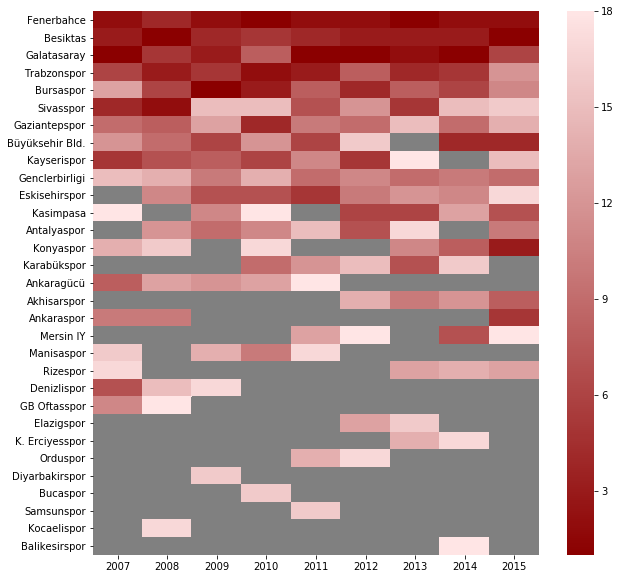

In [298]:
b = pd.DataFrame()
seasons = points_df['Season'].unique()
for s in seasons:
    x = points_df[points_df['Season'] == s].copy()
    x = x.sort_values('Points',ascending = False)
    x['Ranking'] = np.arange(1, len(x)+1)
    b = b.append(x)

heatmap_data = b[['Club','Season','Ranking']]
data = [tuple(x) for x in heatmap_data.values]

df_d = pd.DataFrame(index = b['Club'].unique(), columns = seasons)

for d in data:
    df_d.at[d[0],d[1]] = d[2]
    
df_dm = df_d.fillna(25)
df_d['Mean'] = df_dm.mean(axis=1)
df_d = df_d.sort_values('Mean')
df_d = df_d.drop('Mean', axis=1)
df_d = df_d.fillna(np.nan)

plt.rcParams["figure.figsize"] = [10,10]
#cmap = sb.cubehelix_palette(as_cmap=True, light=.9, start = .45, reverse = True)
cmap = sb.light_palette('darkred',reverse=True, as_cmap=True)
cmap.set_bad('Grey')
#sb.choose_cubehelix_palette(as_cmap=True)
sb.heatmap(df_d,cmap=cmap)
df_d.applymap(lambda x: '%.0f' % x)

# Market Values of a Club's Players in a Season (Visualization)

    - Change club and season parameters on the last line.

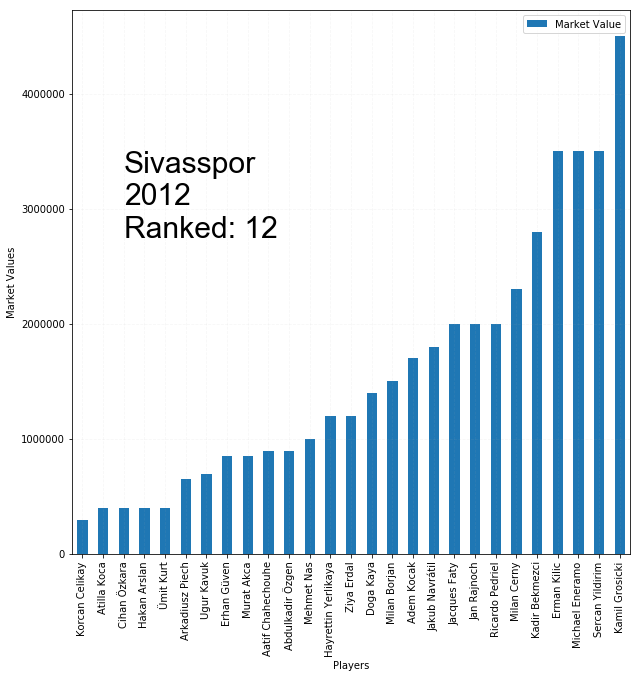

In [299]:
def marketPlot(_club,_season):
    x = players_df[(players_df['Club']==_club)&(players_df['Season']==_season)]
    x.sort_values('Market Value')
    rank = heatmap_data[(heatmap_data['Club']==_club)&(heatmap_data['Season']==_season)]['Ranking'].values[0]
    
    # Visualize. Plot by bar format.
    x[['Market Value']].plot.bar();
    plt.xticks(np.arange(0, len(x)),x['Player'])
    plt.xlabel('Players')
    plt.ylabel('Market Values')
    inplot_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
    plt.text(2, x["Market Value"].iloc[-1]*3/5, _club + "\n" + str(_season) + '\nRanked: '+str(rank), **inplot_font)
    plt.grid(alpha=0.1,linestyle='--')
    
marketPlot('Sivasspor',2012)

## Total Market Value vs. Points in a given season

In this scatter plot, we represent the relationship between total market value and points of teams. As seen, the most valued teams are more likely to gather higher points.
    -  Change season parameter on the last line.

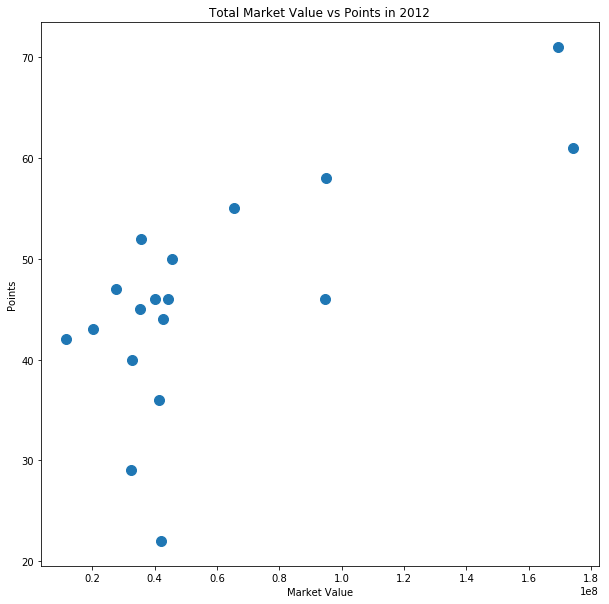

In [300]:
def market_vs_Points_Plot(_season):
    x = players_df[players_df['Season']==_season]
    grouped = x.groupby(['Club'])
    total_market_value = grouped['Market Value'].sum().reset_index()
    total_market_value = pd.merge(total_market_value, points_df[points_df['Season']==_season], how='left', on='Club')
    # Visualize. Plot by bar format.
    total_market_value.plot.scatter(x='Market Value', y='Points',s=100, figsize=(10,10), title='Total Market Value vs Points in ' + str(_season))

market_vs_Points_Plot(2012)

## Dividing The Points of the Clubs in the Same Season to Season's Champion

A club's point's meaning is related to the other clubs performance in the season. For instance a club with 60 points could be ranked 2nd in season x, while another club with 60 points in season y is in the 5th place. Therefore, to represent the local (seasonal) properties correctly in global scale (all seasons in same place), for each season we divided clubs' points to the season's champion.

# Implemented Features

Features used so far (for each club, each season):

- Average age
- Median of market values
- Variance of market values
- Mean & median market values of Turks
- Mean & median market values of foreign players
- Means of top N players' values
- isPromoted, if a team has just promoted that year
- Squad stability
- isBigClub (Fenerbahçe, Besiktas, Galatasaray, Trabzonspor)
- Number of nationalities

Features considered but not implemented:

- Previous season point
- Market value change

# Feature Generation Cell

In [475]:
def stabilityRatio(row,players_df):
    s1 = set(players_df[(players_df['Season']==row['Season']-1) & (players_df['Club']==row['Club'])]['Player'])
    s2 = set(players_df[(players_df['Season']==row['Season']) & (players_df['Club']==row['Club'])]['Player'])
    return len(pd.Series(list( s1 & s2 ))) / len(list( s2 ))

In [503]:
#pd.options.mode.chained_assignment = 'raise'
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

# Group players by season and club, respectively.
grouped = players_df.groupby(['Season', 'Club'])
# Take means of ages for all clubs in each season.
age_mean = grouped['Age'].mean().reset_index()

# Take medians of market values for each club, each season.
value_median = grouped['Market Value'].median().reset_index()
value_median = value_median.rename(columns={'Market Value': 'Median Market Value'})

# Take variances of market values for each club, each season.
value_variance = grouped['Market Value'].std().reset_index()
value_variance = value_variance.rename(columns={'Market Value': 'Market Value Variance'})

# Take means or medians of Turkish players' values for each club, each season.
turkish = players_df[players_df['Foreign']==0]
turkish = turkish.groupby(['Season', 'Club'])['Market Value'].mean().reset_index()
turkish = turkish.rename(columns={'Market Value': 'Turks Value'})

# Take means or medians of foreign players' values for each club, each season.
foreign = players_df[players_df['Foreign']==1]
foreign = foreign.groupby(['Season', 'Club'])['Market Value'].median().reset_index()
foreign = foreign.rename(columns={'Market Value': 'Foreign Value'})

# Take means of top N players' values for each club, each season.
N = 7
top_players_mean = players_df.groupby(['Season','Club'])['Market Value'].nlargest(N).to_frame()
top_players_mean = top_players_mean.groupby(['Season','Club']).mean().reset_index()
top_players_mean = top_players_mean.rename(columns={'Market Value': 'Top Players Mean'})

nationality_ratio = grouped['Nationality'].unique().reset_index()
#nationality_ratio['Nationality'] = nationality_ratio.apply(lambda row: len(row['Nationality']), axis=1)

# Merge all features for each club, each season.
result = pd.merge(age_mean, value_median, how='left', on=['Season', 'Club'])
#result = pd.merge(age_mean, value_variance, how='left', on=['Season', 'Club'])
result = pd.merge(result, turkish, how='left', on=['Season', 'Club'])
#result = pd.merge(result, foreign, how='left', on=['Season', 'Club'])
#result = pd.merge(result, top_players_mean, how='left', on=['Season', 'Club'])


bigClubs = ['Fenerbahce','Galatasaray','Besiktas','Trabzonspor']
# Add a column indicating if a team is just promoted to the Super Lig, in that season.
result['Promoted'] = result.apply(lambda row: not ((result['Season'] == row['Season']-1) & (result['Club'] == row['Club'])).any(), axis=1)
# Add a column indicating if a team is a bigClub
result['IsBig'] = result.apply(lambda row: row['Club'] in bigClubs, axis=1)
result['Stability'] = result.apply(lambda row: stabilityRatio(row, players_df) ,axis=1)
result['Nationality No'] = nationality_ratio.apply(lambda row: len(row['Nationality']), axis=1)

#result['Stability'] = result['Stability'].replace(to_replace=0, value=result['Stability'].mean())


# Create a dataframe list. Each element in the list is a season dataframe.
seasons=result['Season'].unique().tolist()
###### CHANGE TEST YEAR HERE ######
seasons.remove(2015)
seasons.append(2015)
###### CHANGE TEST YEAR HERE ######
season_dfs = [result[result.Season==s].copy() for s in seasons]


# Create dataframe y from points sheet in the excel.
y = points_df.set_index(['Season', 'Club']).sort_index(kind='mergesort').reset_index()


#df_for_later = result.copy()
#df_for_later = pd.merge(df_for_later, y, how='left', on=['Season','Club'])


# Scale Average Market Values & Turks' mean values of teams between 0 and 1, for each season.
for season_df in season_dfs:
    season_df.loc[:,'Median Market Value'] = scaler.fit_transform(season_df[['Median Market Value']])
    #season_df.loc[:,'Market Value Variance'] = scaler.fit_transform(season_df[['Market Value Variance']])
    season_df.loc[:,'Turks Value']  = scaler.fit_transform(season_df[['Turks Value']])
    #season_df.loc[:,'Foreign Value']  = scaler.fit_transform(season_df[['Foreign Value']])    
    #season_df.loc[:,'Top Players Mean']  = scaler.fit_transform(season_df[['Top Players Mean']])


# Final dataframe X.
X = pd.concat(season_dfs, ignore_index=True)

# Create a dataframe list. Each element in the list is a season dataframe.
season_dfs = [y.loc[y.Season==s].copy() for s in seasons]

# Divide each point to max point of the corresponding season
for season_df in season_dfs:
    unnorm_y = np.array(season_df['Points']).reshape(len(season_df['Points']), 1)
    unnorm_y = np.divide(unnorm_y, np.amax(unnorm_y))
    season_df.loc[:,'Points'] = unnorm_y

# Concatenate all seasons
y = pd.concat(season_dfs, ignore_index=True)

# Merge X and y to manage easily.
X = pd.merge(X, y, how='left', on=['Season', 'Club'])
# Drop null values, Ankaraspor in 2009.
X.dropna(inplace=True)
df_for_later = X

clubs = X['Club'].to_frame()
clubs.columns = ['Club']

# In the first season of given data, assume none of the teams are promoted
X.loc[:18,'Promoted'] = False

Z = X.copy()
X = X.drop(['Club','Points','Season'], axis=1)
X

,Age,Median Market Value,Turks Value,Promoted,IsBig,Stability,Nationality No
0,25.258065,0.272727,0.108248,False,False,0.000000,11
1,24.862069,0.666667,0.429002,False,False,0.000000,12
2,24.068966,0.969697,0.660156,False,True,0.000000,10
3,24.352941,0.136364,0.164129,False,False,0.000000,13
4,25.896552,0.181818,0.212270,False,False,0.000000,6
5,25.034483,0.212121,0.140945,False,False,0.000000,7
6,25.576923,1.000000,0.442864,False,True,0.000000,9
7,22.718750,0.030303,0.000000,False,False,0.000000,7
8,25.280000,0.969697,1.000000,False,True,0.000000,9
9,25.545455,0.363636,0.237585,False,False,0.000000,9


# Correlation Between Features

In [477]:
Z.drop(['Season','Points'], axis=1).corr()

,Age,Median Market Value,Turks Value,Promoted,IsBig,Stability,Nationality No
Age,1.000000,0.090893,0.145812,0.044439,0.095972,0.062710,0.043372
Median Market Value,0.090893,1.000000,0.924625,-0.085658,0.851521,0.264628,-0.210650
Turks Value,0.145812,0.924625,1.000000,-0.185901,0.848939,0.358772,-0.184427
Promoted,0.044439,-0.085658,-0.185901,1.000000,-0.164246,-0.862582,-0.079430
IsBig,0.095972,0.851521,0.848939,-0.164246,1.000000,0.299271,-0.114247
Stability,0.062710,0.264628,0.358772,-0.862582,0.299271,1.000000,-0.043989
Nationality No,0.043372,-0.210650,-0.184427,-0.079430,-0.114247,-0.043989,1.000000


# Feature Set Testing With Tau Values
- Cross validation between seasons for each feature combination.
- See line 8.

In [478]:
#arranging the X's for the 3 item combinations of features, used in determining the feature set with greatest average tau value on dataset 
features = list(Z)
features.remove('Season')
features.remove('Club')
features.remove('Points')

#CHANGE THE NUMBER AT THE END OF BELOW LINE TO CHANGE THE NUMBER OF FEATURES IN MODEL------------------------
Z_list = [Z[list(comb) + ['Season','Club','Points']].copy() for comb in it.combinations(features, 4)]
#CHANGE THE NUMBER AT THE END OF ABOVE LINE TO CHANGE THE NUMBER OF FEATURES IN MODEL------------------------

tau_results = []
for Z_i in Z_list:
    tau_values = []
    for season in seasons:
        removed_season = Z_i[Z_i['Season'] == season]
        Z_temp = Z_i[Z_i['Season']!= season].append(removed_season)
        Z_points = Z_temp['Points'].copy()
        Z_clubs = Z_temp['Club'].copy()
        club_size = len(Z_i[Z_i['Season'] == season])
        Z_temp = Z_temp.drop(['Points', 'Season','Club'], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(Z_temp,Z_points, test_size=club_size/len(Z_i), shuffle=False)
        # Apply the linear regression model.
        model = LinearRegression(fit_intercept=False)
        model.fit(X_train, y_train)

        # Predict the test set and convert the prediction to a dataframe.
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['Scaled Points']
        
        # Add club names & Predicted Rankings to pred df.
        pred['Club'] = Z_clubs.tail(club_size).values.tolist()
        pred = pred.sort_values('Scaled Points', ascending = False)
        pred['Predicted Ranking'] = np.arange(1, len(pred) + 1)
        pred = pred.sort_index()

        # Add club names & Real Rankings to y_test df.
        y_test = y_test.to_frame()
        y_test['Club'] = Z_clubs.tail(club_size).values.tolist()
        y_test = y_test.sort_values('Points', ascending = False)
        y_test['Real Ranking'] = np.arange(1, len(pred) + 1)
        y_test = y_test.sort_index()

        # Find tau value.
        tau, _ = kendalltau(pred['Predicted Ranking'], y_test['Real Ranking'])
        # Print tau both to file and screen
        tau_values.append(tau)
        #print('Season: '+ str(season) + '. Tau value is:',tau)
    features = list(Z_i)
    features.remove('Season')
    features.remove('Club')
    features.remove('Points')
    #print(tau_values)
    tau_results.append((features, np.mean(tau_values), np.std(tau_values)))
result = pd.DataFrame(tau_results,columns = ['Features','Mean Tau Value','Tau Std'])
pd.set_option('display.max_colwidth', -1)
result.sort_values('Mean Tau Value',ascending=False)

,Features,Mean Tau Value,Tau Std
3,"[Age, Median Market Value, Turks Value, Nationality No]",0.510349,0.080625
8,"[Age, Median Market Value, IsBig, Nationality No]",0.491649,0.101338
15,"[Age, Turks Value, Stability, Nationality No]",0.486020,0.088775
1,"[Age, Median Market Value, Turks Value, IsBig]",0.482934,0.074486
12,"[Age, Turks Value, Promoted, Nationality No]",0.482571,0.091762
6,"[Age, Median Market Value, Promoted, Nationality No]",0.480392,0.120122
2,"[Age, Median Market Value, Turks Value, Stability]",0.476580,0.102501
9,"[Age, Median Market Value, Stability, Nationality No]",0.472585,0.119423
7,"[Age, Median Market Value, IsBig, Stability]",0.469317,0.109470
11,"[Age, Turks Value, Promoted, Stability]",0.468773,0.090291


## Final Feature Set
According to our cross validation test above, we have chosen the best features as:
- Age
- Median Market Value
- Mean Turkish Value
- Number of Nationalities

# Features and their relationship with the points are shown below
+ The points are scaled between 0 and 1 since they are divided to their corresponding season champions score.

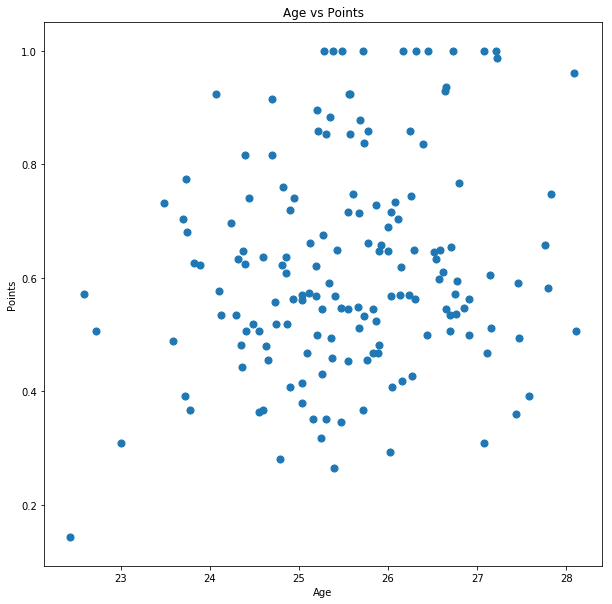

In [480]:
# Correlation between average ages and points are not clear as other features.
df_for_later.plot.scatter(x='Age', y='Points', figsize=(10,10), title="Age vs Points", s=50)    

### Relationship between median market value and points
The relationship between median market value and scaled points is shown in the scatter plot below. The positive correlation between two is clearly seen in the plot. In general, with greater median market value comes greater points. 

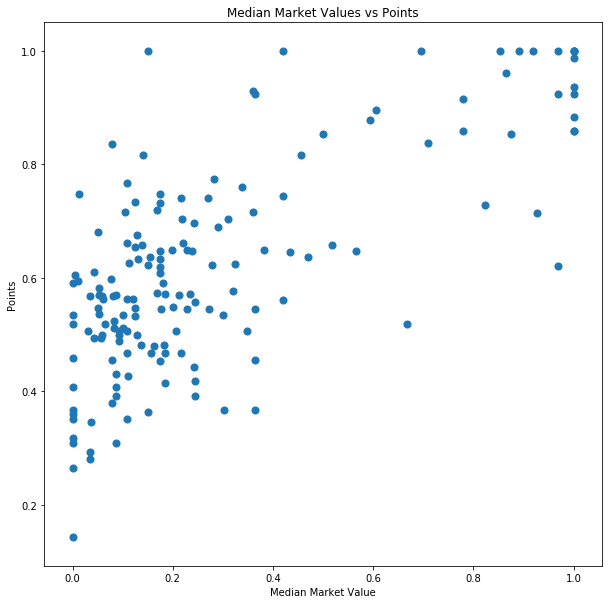

In [481]:
# One can easily see that there is a positive correlation between median market values and points of the teams.
df_for_later.plot.scatter(x='Median Market Value', y='Points', title="Median Market Values vs Points", figsize=(10,10), s=50)

## Number of Clubs that Relegated in Their Debut Season (Visualization)

In this bar plot, we visualize the number of clubs that relegated in their debut season. We thought that the new comers in the league are more fragile and more likely to end the season in bottom three. Therefore we used this as as a feature.

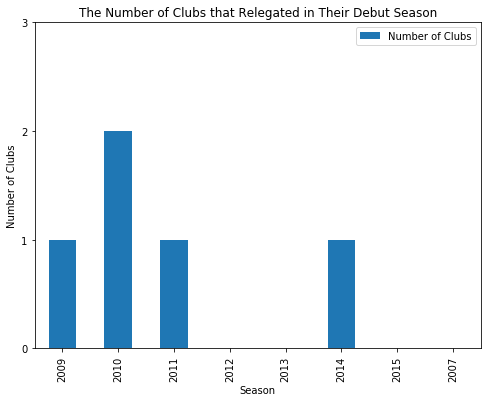

In [482]:
data = points_df.copy()
data['Promoted'] = data.apply(lambda row: not ((data['Season'] == row['Season']-1) & (data['Club'] == row['Club'])).any(), axis=1)
data.at[:18,'Promoted'] = False
df_debut = pd.DataFrame(index=seasons, columns = ['Number of Clubs'])
for s in seasons:
    x = data[data['Season']==s]
    x = x[-3:]
    number = x[x['Promoted']==True]['Promoted'].count()
    df_debut.at[s,'Number of Clubs'] = number

df_debut[1:].plot.bar()
yint = range(0, 4)
plt.yticks(yint)
plt.xlabel('Season')
plt.ylabel('Number of Clubs')
plt.title('The Number of Clubs that Relegated in Their Debut Season')

plt.show()

### Correlation between Turks' value and points
The relationship between market value of Turkish players and scaled points is shown in the scatter plot below. The positive correlation between two is clearly seen in the plot. In general, with greater average market value of Turks comes greater points. 

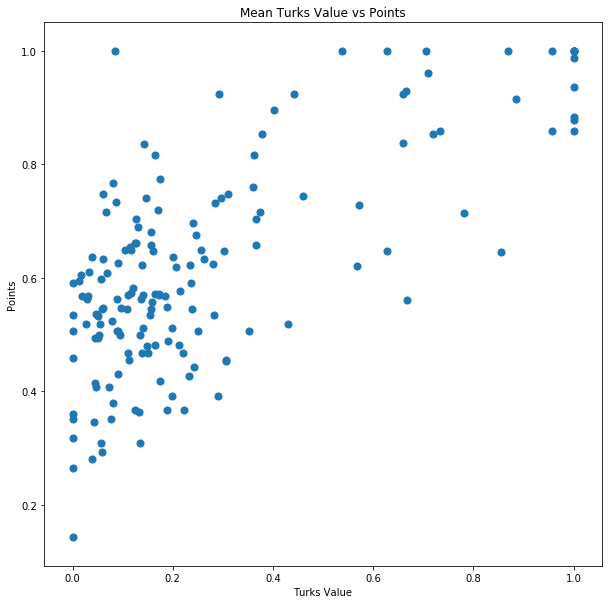

In [483]:
# One can easily see that there is a positive correlation between median market values of Turkish players 
# and points of the teams.
df_for_later.plot.scatter(x='Turks Value', y='Points', title="Mean Turks Value vs Points", figsize=(10,10), s=50)

### Correlation between number of nationality and points
The relationship between number of nationality in a team and scaled points is shown in the scatter plot below. From the plot, we can see that a team should not buy a lot of foreign players from lots of different countries because as the team becomes more multinational, the team loses its harmony.

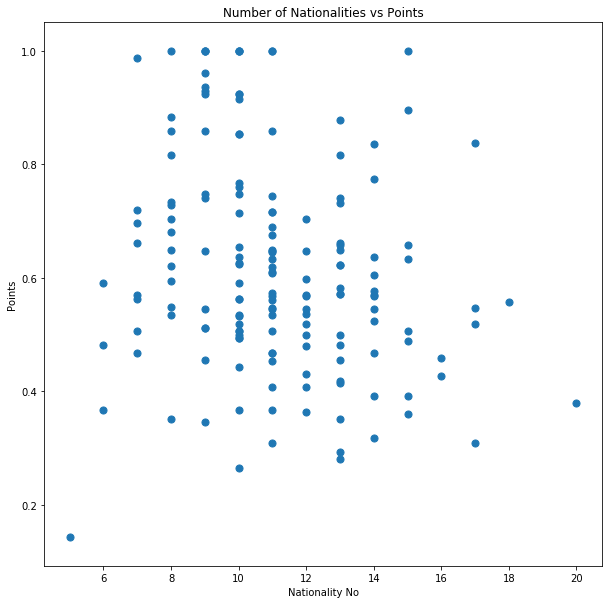

In [485]:
df_for_later.plot.scatter(x='Nationality No', y='Points', title="Number of Nationalities vs Points", figsize=(10,10), s=50)

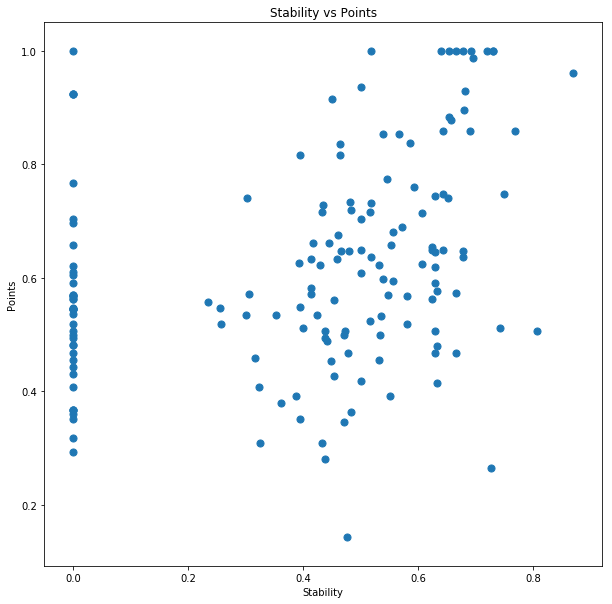

In [487]:
# One can easily see that there is a positive correlation between top N-players' values 
# and points of the teams.
df_for_later.plot.scatter(x='Stability', y='Points', title="Stability vs Points", figsize=(10,10), s=50)

# Tau Evaluation & Predicted Ranking Visualizations for Season 2015

Tau value is: 0.5816993464052289
Features:
	- Age
	- Median Market Value
	- Turks Value
	- Nationality No
Mean difference: 2.889
Median difference: 2.0


,Points,Club,Real Ranking,Predicted Ranking,Difference
3,1.000000,Besiktas,1,3,2
7,0.936709,Fenerbahce,2,1,1
13,0.835443,Konyaspor,3,12,9
5,0.746835,Büyüksehir Bld.,4,4,0
1,0.658228,Ankaraspor,5,7,2
8,0.645570,Galatasaray,6,2,4
11,0.632911,Kasimpasa,7,6,1
0,0.582278,Akhisarspor,8,10,2
2,0.569620,Antalyaspor,9,11,2
10,0.569620,Genclerbirligi,10,13,3


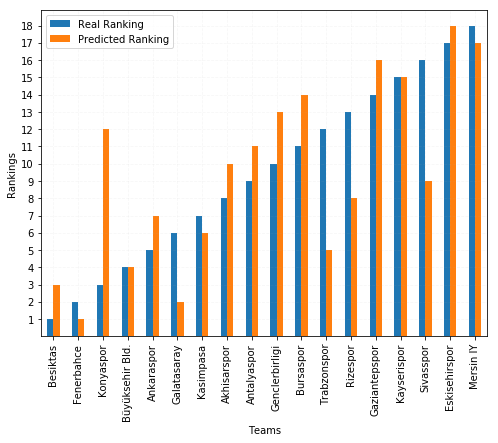

In [504]:
from sklearn.model_selection import train_test_split

X = X.drop(['Promoted', 'IsBig', 'Stability'], axis = 1 )
X_train, X_test, y_train , y_test = train_test_split(X,y['Points'],
                                                 test_size=18/len(y), shuffle=False)

# Apply the linear regression model.
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Predict the test set and convert the prediction to a dataframe.
pred = model.predict(X_test)
pred = pd.DataFrame(pred)
pred.columns = ['Scaled Points']

# Add club names & Predicted Rankings to pred df.
pred['Club'] = clubs.tail(18)['Club'].values.tolist()
pred = pred.sort_values('Scaled Points', ascending = False, kind='mergesort')
pred['Predicted Ranking'] = np.arange(1, len(pred) + 1)
pred = pred.sort_index(kind='mergesort')

# Add club names & Real Rankings to y_test df.
y_test = y_test.to_frame()
y_test['Club'] = clubs.tail(18)['Club'].values.tolist()
y_test = y_test.sort_values('Points', ascending = False,kind='mergesort')
y_test['Real Ranking'] = np.arange(1, len(pred) + 1)
y_test = y_test.sort_index(kind='mergesort')

# Find tau value.
tau, _ = kendalltau(pred['Predicted Ranking'], y_test['Real Ranking'])
# Print tau both to file and screen
print('Tau value is:',tau)

# Merge real & predicted rankings to a single df
rank_df = pd.merge(y_test, pred[['Club', 'Predicted Ranking']], how='left', on=['Club'])
# Add a difference column abs(Real rank, Predicted rank)
rank_df['Difference'] = abs(rank_df['Real Ranking'].values - rank_df['Predicted Ranking'].values)

# Sort by real rankings
rank_df = rank_df.sort_values('Real Ranking', ascending = True,kind='mergesort')

# Set the figure size
plt.rcParams["figure.figsize"] = [8,6]

# Visualize. Plot by bar format.
rank_df[['Real Ranking', 'Predicted Ranking']].plot.bar();
plt.xticks(rank_df['Real Ranking'].values-1,rank_df['Club'].values)
plt.yticks(rank_df['Real Ranking'].values,rank_df['Real Ranking'].values)
plt.xlabel('Teams')
plt.ylabel('Rankings')
plt.grid(alpha=0.1,linestyle='--')


#Print used features, mean&median of differences
print('Features:')
for i in list(X)[0:]:
    print('\t-',i)
print('Mean difference:', "{0:.3f}".format(rank_df['Difference'].mean()))
print('Median difference:', rank_df['Difference'].median())


rank_df

# Rıza's Functions

## This function constructs dataframe X with our final features

In [489]:
# Fill this function to construct a data frame X that contains your final features extracted from the dataset
def construct_features(players_df):
    #pd.options.mode.chained_assignment = 'raise'
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    scaler = MinMaxScaler()

    # Group players by season and club, respectively.
    grouped = players_df.groupby(['Season', 'Club'])
    # Take means of ages for all clubs in each season.
    age_mean = grouped['Age'].mean().reset_index()

    # Take medians of market values for each club, each season.
    value_median = grouped['Market Value'].median().reset_index()
    value_median = value_median.rename(columns={'Market Value': 'Median Market Value'})


    # Take means or medians of Turkish players' values for each club, each season.
    turkish = players_df[players_df['Foreign']==0]
    turkish = turkish.groupby(['Season', 'Club'])['Market Value'].mean().reset_index()
    turkish = turkish.rename(columns={'Market Value': 'Turks Value'})

    # Merge all features for each club, each season.
    result = pd.merge(age_mean, value_median, how='left', on=['Season', 'Club'])
    result = pd.merge(result, turkish, how='left', on=['Season', 'Club'])
    nationality_ratio = grouped['Nationality'].unique().reset_index()
    result['Nationality No'] = nationality_ratio.apply(lambda row: len(row['Nationality']), axis=1)

    # Create a dataframe list. Each element in the list is a season dataframe.
    seasons=result['Season'].unique().tolist()
    ###### CHANGE TEST YEAR HERE ######
    #seasons.remove(2015)
    #seasons.append(2015)
    ###### CHANGE TEST YEAR HERE ######
    season_dfs = [result[result.Season==s].copy() for s in seasons]


    # Scale Average Market Values & Turks' mean values of teams between 0 and 1, for each season.
    for season_df in season_dfs:
        season_df.loc[:,'Median Market Value'] = scaler.fit_transform(season_df[['Median Market Value']])
        season_df.loc[:,'Turks Value']  = scaler.fit_transform(season_df[['Turks Value']])
    
    # Final dataframe X.
    X = pd.concat(season_dfs, ignore_index=True)

    # Create dataframe y from points sheet in the excel.
    y = points_df.set_index(['Season', 'Club']).sort_index(kind='mergesort').reset_index()
    # Create a dataframe list. Each element in the list is a season dataframe.
    season_dfs = [y.loc[y.Season==s].copy() for s in seasons]

    # Divide each point to max point of the corresponding season
    for season_df in season_dfs:
        unnorm_y = np.array(season_df['Points']).reshape(len(season_df['Points']), 1)
        unnorm_y = np.divide(unnorm_y, np.amax(unnorm_y))
        season_df.loc[:,'Points'] = unnorm_y

    # Concatenate all seasons
    y = pd.concat(season_dfs, ignore_index=True)

    # Merge X and y to manage easily.
    X = pd.merge(X, y, how='left', on=['Season', 'Club'])
    # Drop null values, Ankaraspor in 2009.
    X.dropna(inplace=True)
    df_for_later = X

    clubs = X['Club'].to_frame()
    clubs.columns = ['Club']
    
    df_for_later = X
    X = X.drop(['Club','Points'], axis=1)
    return X


## This function constructs dataframe y that contains labels of the test data.

In [490]:
# Fill this function to construct a data frame y that contains the labels of the test data
def construct_labels(points_df):
    # Create dataframe y from points sheet in the excel.
    y = points_df.set_index(['Season', 'Club']).sort_index(kind='mergesort').reset_index()
    #Create Seasons
    seasons = points_df['Season'].unique()
    # Create a dataframe list. Each element in the list is a season dataframe.
    season_dfs = [y.loc[y.Season==s].copy() for s in seasons]

    # Divide each point to max point of the corresponding season
    for season_df in season_dfs:
        unnorm_y = np.array(season_df['Points']).reshape(len(season_df['Points']), 1)
        unnorm_y = np.divide(unnorm_y, np.amax(unnorm_y))
        season_df.loc[:,'Points'] = unnorm_y

    # Concatenate all seasons
    y = pd.concat(season_dfs, ignore_index=True)
    
    return y['Points'].to_frame()

## Point to Rank

In [491]:
# If you try to choose to predict points instead of rankings then you should implement this function as well
# to generate rankings. If you predict the rankings directly, you can leave this function as it is.
def convert_points_to_rankings(y):
    y = y.sort_values('Points',ascending=False)
    y['Ranking'] = np.arange(1, len(y)+1)
    y = y.sort_index()
    return y['Ranking'].to_frame()

## Evaluation

In [492]:
# This function will evaluate your features test performance using the ranking predictions
def compute_test_score(outfile_name):
    # X_test should contain the feature you engineered and y_test should contain the corresponding labels, which are team rankings 
    X_train = construct_features(pd.read_excel('train_data.xlsx',sheet_name='Player'))
    y_train = construct_labels(pd.read_excel('train_data.xlsx',sheet_name='Points'))
    
    X_test = construct_features(pd.read_excel('test_data.xlsx',sheet_name='Player'))
    y_test = construct_labels(pd.read_excel('test_data.xlsx',sheet_name='Points'))

    # This is the regression model you will use
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(X_train,y_train)
    # Your model's predictions will be stored in this array
    predictions = final_model.predict(X_test)
    # Your model can predict either points or rankings. If necessary, change the function above
    predictions = convert_points_to_rankings(predictions)
    y_test = convert_points_to_rankings(y_test)
    # Your performance on the test set
    tau, _ = kendalltau(predictions, y_test)
    # Print tau both to file and screen
    print(tau)
    f = open(outfile_name, 'w')
    f.print(tau)
    f.close()

#outfile name should have the format ID1_ID2_ID3.txt
outfile_name = "2013400069_2013400198_2013400213.txt"
compute_test_score(outfile_name)

FileNotFoundError: [Errno 2] No such file or directory: 'test_data.xlsx'